# 📖 Background : 

We will be using the Orange Telecom's Churn Dataset to create predictive models. The dataset contains customer activity data (features) and a churn label that indicates whether a customer canceled their subscription. Two datasets are available: churn-80 and churn-20. Although both datasets originate from the same batch, they have been split into an 80/20 ratio. Since having more data is beneficial for creating machine learning models, we will use the larger churn-80 dataset for training and cross-validation, while the smaller churn-20 dataset will be used for final testing and evaluating the model's performance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency 
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from collections import Counter 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict,StratifiedKFold,GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, roc_curve, roc_auc_score, f1_score,fbeta_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

plt.style.use("ggplot")

In [2]:
file_path = "/kaggle/input/telecom-churn-datasets/churn-bigml-80.csv"
df = pd.read_csv(file_path)

# 📊 Exploratory Data Analysis:

In [3]:
df.columns

Index(['State', 'Account length', 'Area code', 'International plan',
       'Voice mail plan', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn'],
      dtype='object')

In [4]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [6]:
for column in df.columns:
    unique_values = len(df[column].unique())
    print(f"Number of unique values in {column}: {unique_values}")

Number of unique values in State: 51
Number of unique values in Account length: 205
Number of unique values in Area code: 3
Number of unique values in International plan: 2
Number of unique values in Voice mail plan: 2
Number of unique values in Number vmail messages: 42
Number of unique values in Total day minutes: 1489
Number of unique values in Total day calls: 115
Number of unique values in Total day charge: 1489
Number of unique values in Total eve minutes: 1442
Number of unique values in Total eve calls: 120
Number of unique values in Total eve charge: 1301
Number of unique values in Total night minutes: 1444
Number of unique values in Total night calls: 118
Number of unique values in Total night charge: 885
Number of unique values in Total intl minutes: 158
Number of unique values in Total intl calls: 21
Number of unique values in Total intl charge: 158
Number of unique values in Customer service calls: 10
Number of unique values in Churn: 2


In [7]:
df.describe()

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
count,2666.000000,2666.000000,2666.000000,2666.00000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,100.620405,437.438860,8.021755,179.48162,100.310203,30.512404,200.386159,100.023631,17.033072,201.168942,100.106152,9.052689,10.237022,4.467367,2.764490,1.562641
std,39.563974,42.521018,13.612277,54.21035,19.988162,9.215733,50.951515,20.161445,4.330864,50.780323,19.418459,2.285120,2.788349,2.456195,0.752812,1.311236
min,1.000000,408.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,43.700000,33.000000,1.970000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,408.000000,0.000000,143.40000,87.000000,24.380000,165.300000,87.000000,14.050000,166.925000,87.000000,7.512500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,415.000000,0.000000,179.95000,101.000000,30.590000,200.900000,100.000000,17.080000,201.150000,100.000000,9.050000,10.200000,4.000000,2.750000,1.000000
75%,127.000000,510.000000,19.000000,215.90000,114.000000,36.700000,235.100000,114.000000,19.980000,236.475000,113.000000,10.640000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,50.000000,350.80000,160.000000,59.640000,363.700000,170.000000,30.910000,395.000000,166.000000,17.770000,20.000000,20.000000,5.400000,9.000000


First thing that jumps to mind is that the features have different scales so we need to do normalization techniques, the feature Balance might also contain some outliers since the maximum value is bigger by a big margin from the 3rd quartile.

<AxesSubplot:xlabel='Churn', ylabel='count'>

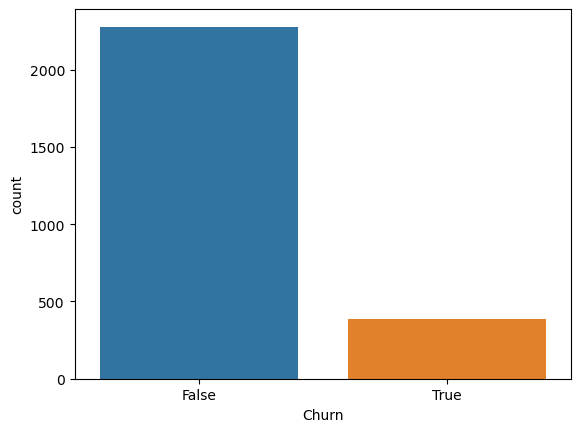

In [8]:
sns.countplot(data = df, x = "Churn")

We can see that our data is imbalanced so we might need to do some data balancing techniques. In this project we are going to try and work with the data as it is then try out various data balancing techniques and see whether or not they improve model performance.

## Does state affect churn?

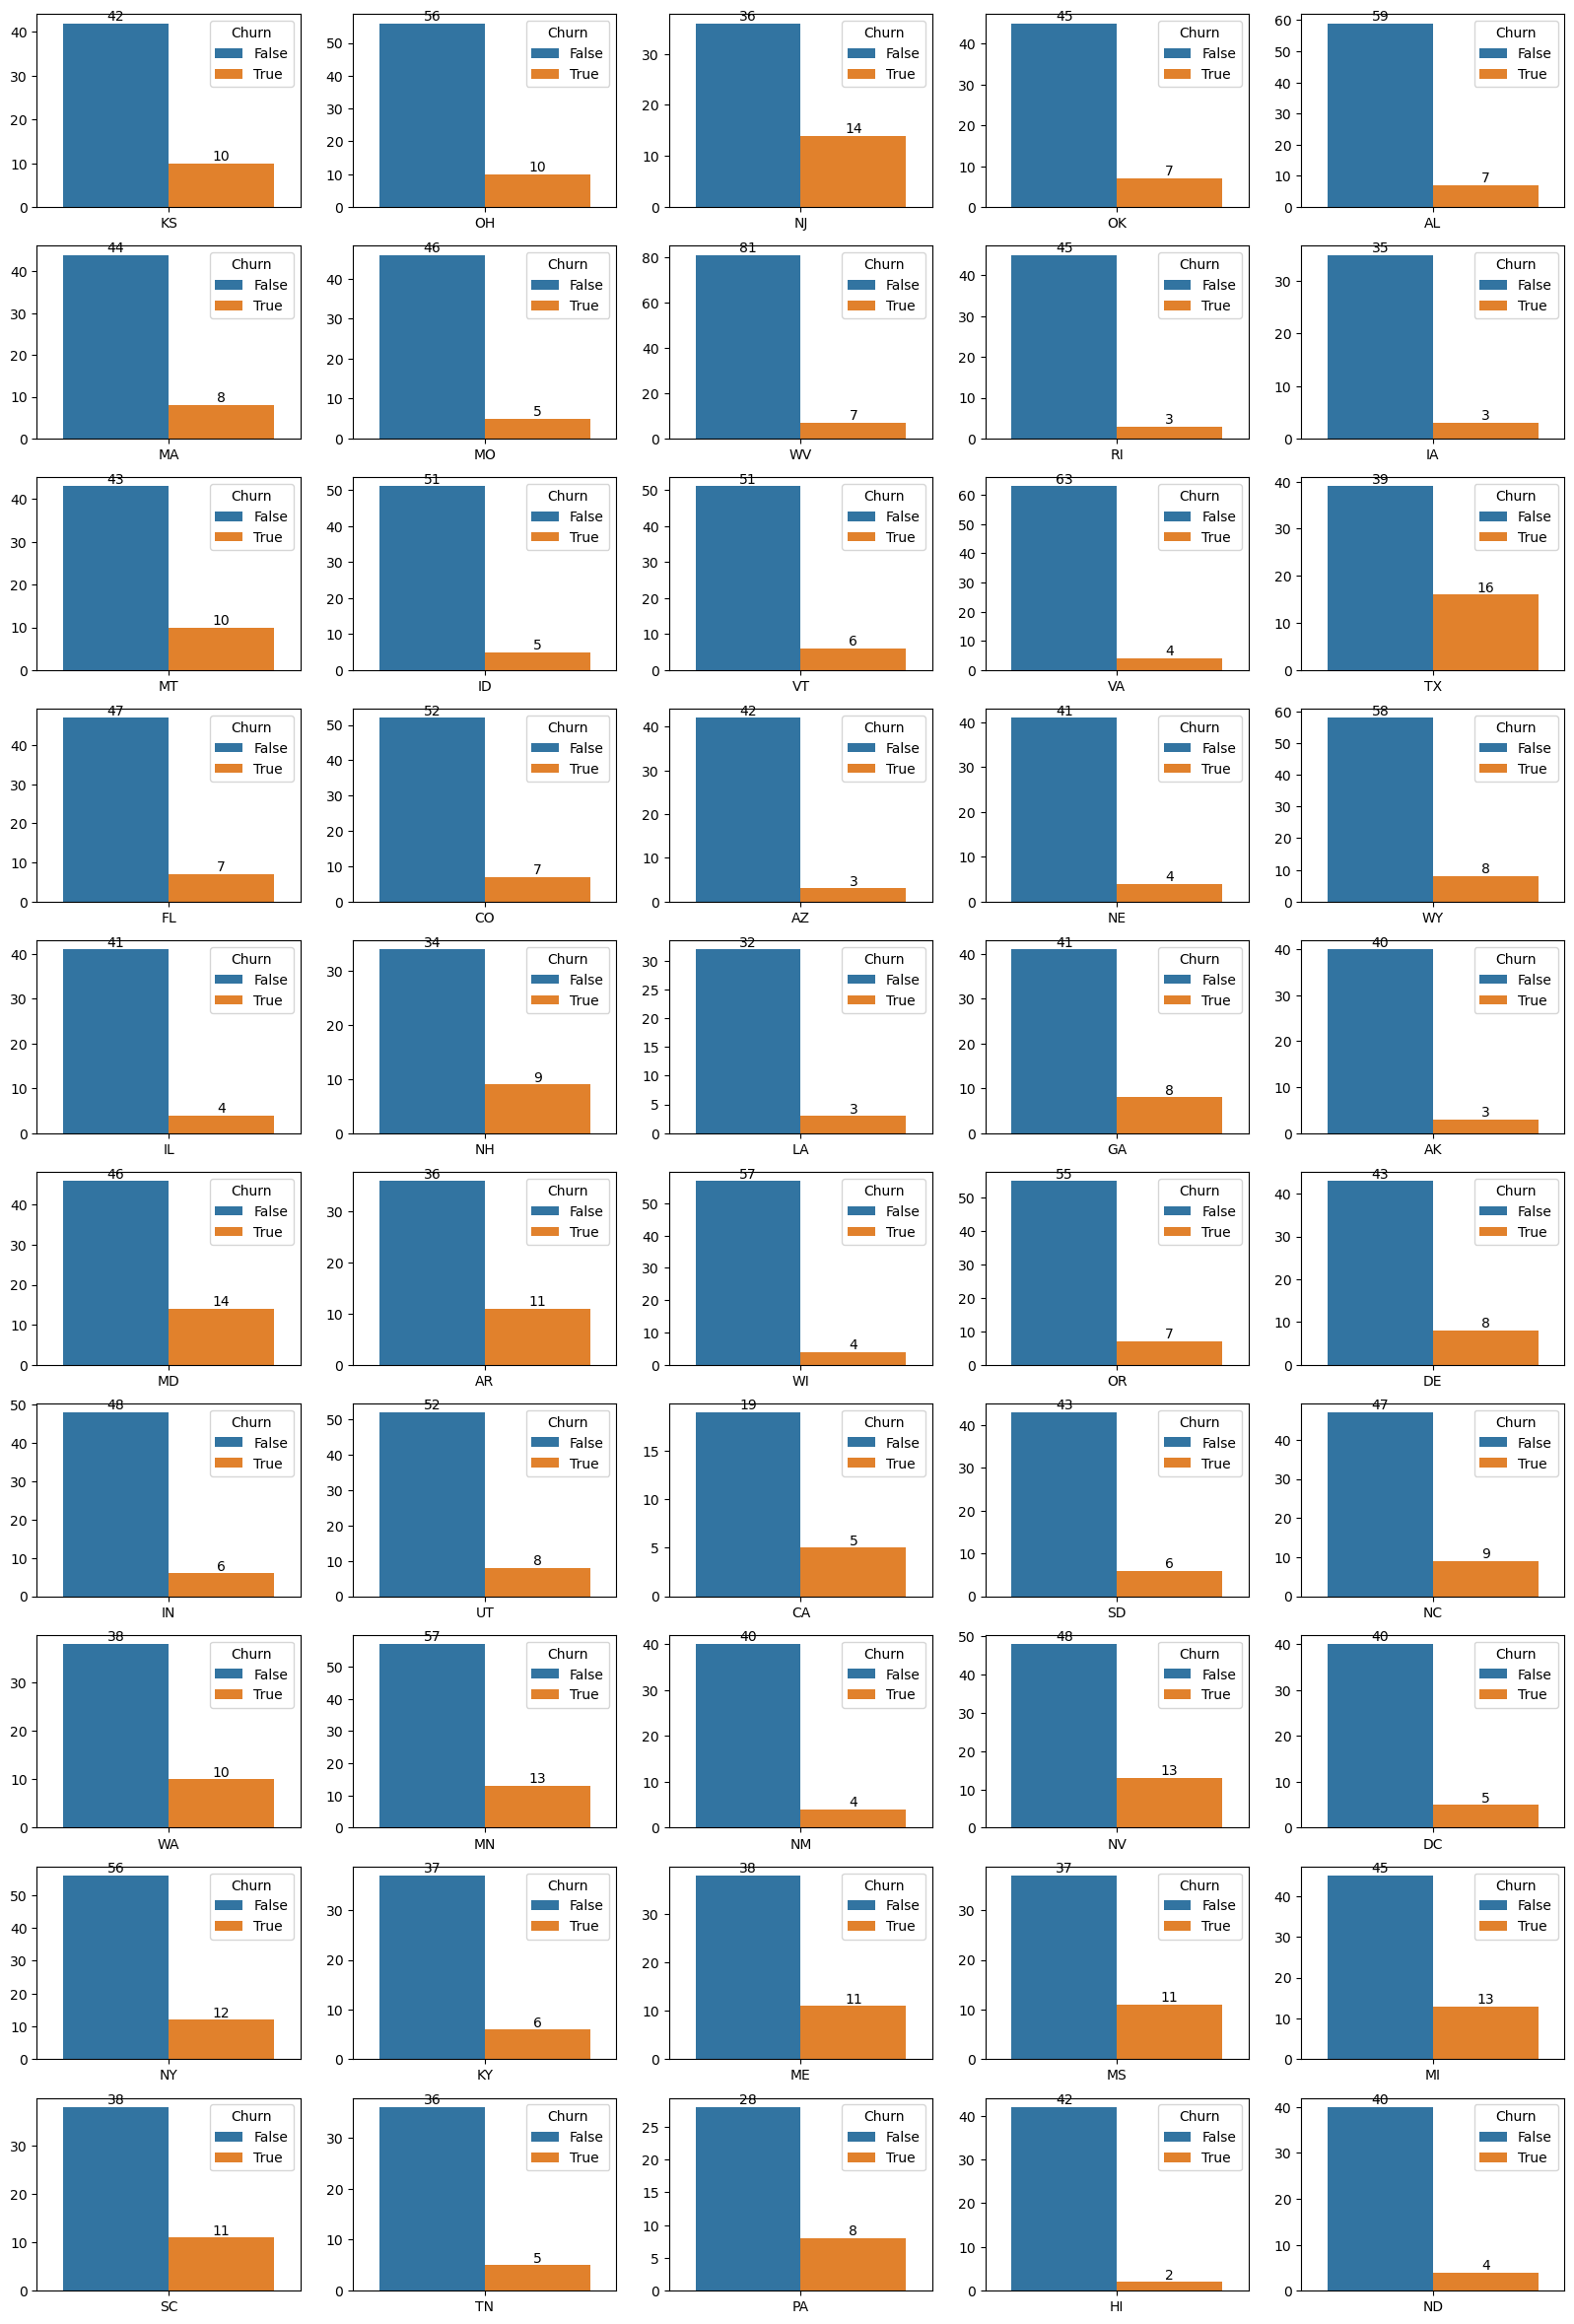

In [9]:
fig, axes = plt.subplots(10,5,figsize = (20,30))
for i in range(len(df.State.unique())-1): 
    # filter for that state 
    state_data = df[df.State == df.State.unique()[i]]
    sns.countplot(data = state_data, x = "State", hue = "Churn", ax = axes[i//5,i%5])
    axes[i//5,i%5].bar_label(axes[i//5,i%5].containers[1])
    axes[i//5,i%5].bar_label(axes[i//5,i%5].containers[0])
    axes[i//5,i%5].set_ylabel("")
    axes[i//5,i%5].set_xlabel("")

We can already see that states might influence the churn rate so that is information we might want to include in our model, so we can be more sure of the dependence of these variables we are going to conduct a chi squared test, which test the effect of a categorical variable on another categorical variable.

The two hypotheses of a chi-square test are:

* Null Hypothesis (H0): There is no significant association between two categorical variables.
* Alternative Hypothesis (Ha): There is a significant association between two categorical variables.

In other words, the test aims to determine whether the observed frequency distribution of a variable differs significantly from the expected frequency distribution under the assumption of independence between the variables (null hypothesis) or if there is evidence that the variables are associated (alternative hypothesis).

In [10]:
def chi_2_test(df, col2,col1 = "Churn"):
    data = pd.crosstab(df[col1], df[col2], rownames=[col1], colnames=[col2])
    stat, p, dof, expected = chi2_contingency(data)
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print(f"{col2} and {col1} are dependant!")
    else : 
        print(f"{col2} and {col1} are independant!")

In [11]:
chi_2_test(df,"State")

p value is 0.004680701679944942
State and Churn are dependant!


Since there are too many states to include, we are going to summarize them into a shorter variable that is more significant and that brings as much information. 

In [12]:
tab = pd.crosstab(df["Churn"], df["State"], rownames=['Churn'], colnames=['State'], normalize = "columns")
tab.T

Churn,False,True
State,,
AK,0.930233,0.069767
AL,0.893939,0.106061
AR,0.765957,0.234043
AZ,0.933333,0.066667
CA,0.791667,0.208333
CO,0.881356,0.118644
CT,0.813559,0.186441
DC,0.888889,0.111111
DE,0.843137,0.156863


In [13]:
churn_more10 = list(tab.iloc[1][((tab.iloc[1] > 0.1) & (tab.iloc[1] < 0.2))].index)
churn_more20 = list(tab.iloc[1][(tab.iloc[1] > 0.2)].index)
churn_less10 = list(tab.iloc[1][tab.iloc[1] < 0.1].index)

In [14]:
df["State"].replace(churn_less10,0, inplace = True)
df["State"].replace(churn_more10,1, inplace = True)
df["State"].replace(churn_more20,2, inplace = True)

We create a cross-tabulation table using the "Churn" and "State" columns from the DataFrame "df" so we can know the proprotions of churners in each state.

Next, we create three lists of states based on their proportion of customers who churned. We use the "iloc" method to access the second row of the table (which contains the proportions of customers who churned for each state) and filter the values to create the three lists.

Finally, we replace the state names in the "df" DataFrame with numeric values based on the proportion of customers who churned. States with a proportion less than 10% are replaced with 0, states with a proportion between 10% and 20% (exclusive) are replaced with 1, and states with a proportion greater than or equal to 20% are replaced with 2.

<AxesSubplot:xlabel='State', ylabel='count'>

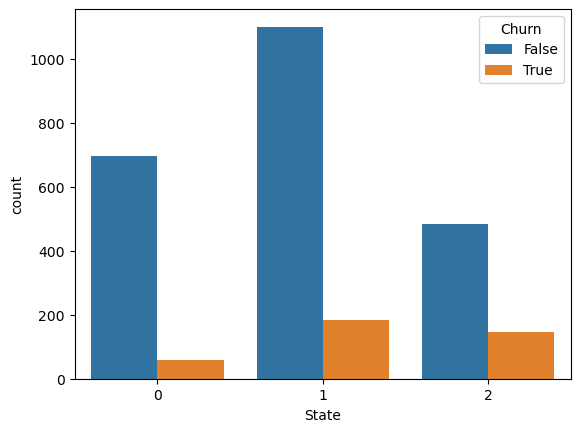

In [15]:
sns.countplot(data = df, x = "State", hue = "Churn")

In [16]:
chi_2_test(df,"State")

p value is 3.164053922894711e-15
State and Churn are dependant!


## Does International plan affect churn?

<AxesSubplot:xlabel='International plan', ylabel='count'>

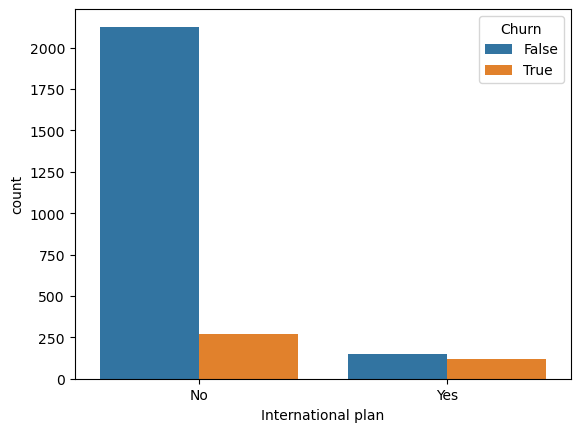

In [17]:
sns.countplot(data = df, x = "International plan", hue = "Churn")

In [18]:
chi_2_test(df,"International plan")

p value is 5.4269405491147075e-46
International plan and Churn are dependant!


## Does Voice mail plan affect churn? 

<AxesSubplot:xlabel='Voice mail plan', ylabel='count'>

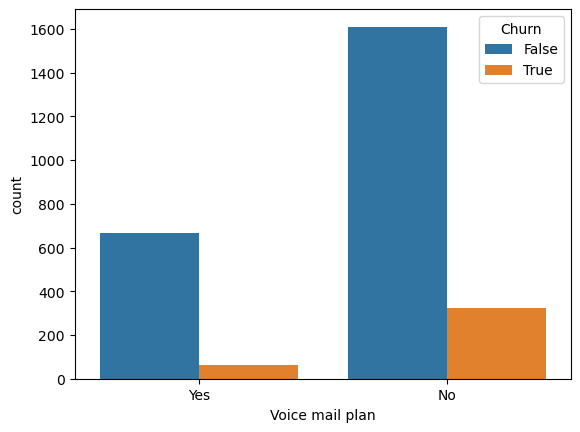

In [19]:
sns.countplot(data = df, x = "Voice mail plan", hue = "Churn")

In [20]:
chi_2_test(df,"Voice mail plan")

p value is 4.079713016862758e-07
Voice mail plan and Churn are dependant!


## Does Customer service calls affect Churn?

[Text(0, 0, '476'),
 Text(0, 0, '846'),
 Text(0, 0, '546'),
 Text(0, 0, '311'),
 Text(0, 0, '69'),
 Text(0, 0, '20'),
 Text(0, 0, '7'),
 Text(0, 0, '3'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

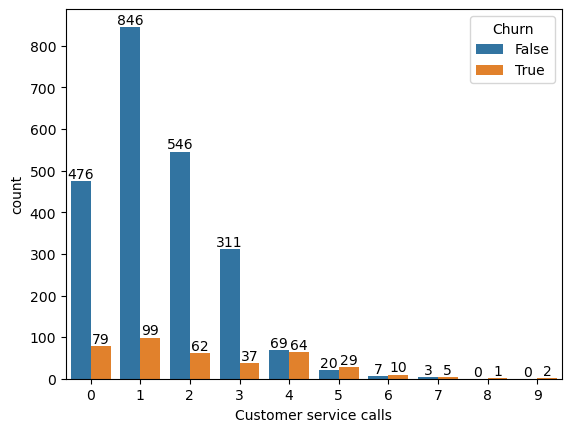

In [21]:
ax = sns.countplot(data = df, x = "Customer service calls", hue = "Churn")
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])

In [22]:
chi_2_test(df,"Customer service calls")

p value is 5.177967803990785e-56
Customer service calls and Churn are dependant!


Since there are also too many unique numbers of customer service calls, we are also going to replace it with a feature that brings as much insight to the model.

In [23]:
df["Customer service calls"]=np.where(df["Customer service calls"] >= 4, 1,0 )

In [24]:
chi_2_test(df,"Customer service calls")

p value is 5.177967803990785e-56
Customer service calls and Churn are dependant!


[Text(0, 0, '476'),
 Text(0, 0, '846'),
 Text(0, 0, '546'),
 Text(0, 0, '311'),
 Text(0, 0, '69'),
 Text(0, 0, '20'),
 Text(0, 0, '7'),
 Text(0, 0, '3'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

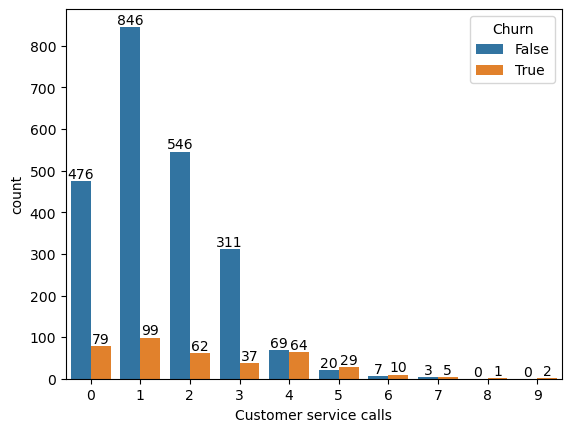

In [25]:
ax = sns.countplot(data = df, x = "Customer service calls", hue = "Churn")
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])

## Does Area Code affect Churn?

In [ ]:
ax = sns.countplot(data = df, x = "Customer service calls", hue = "Churn")
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[0])

In [ ]:
chi_2_test(df,"Area code")

Although the chi_2 test accepts the Null hypothesis (There is no significant association between the two variables), we are leaving it in for the time being!

## How do our numerical variables look like? 

In [26]:
num_cols = ["Account length",
    "Number vmail messages",
    'Total day minutes',
    'Total day calls',
    'Total day charge',
    'Total eve minutes',
    'Total eve calls',
    'Total eve charge',
    'Total night minutes',
    'Total night calls',
    'Total night charge',
    'Total intl minutes',
    'Total intl calls',
    'Total intl charge']

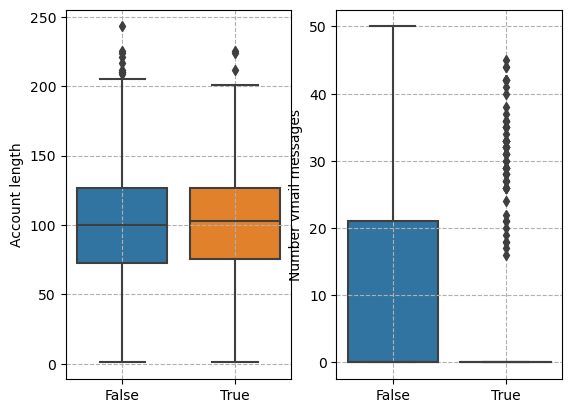

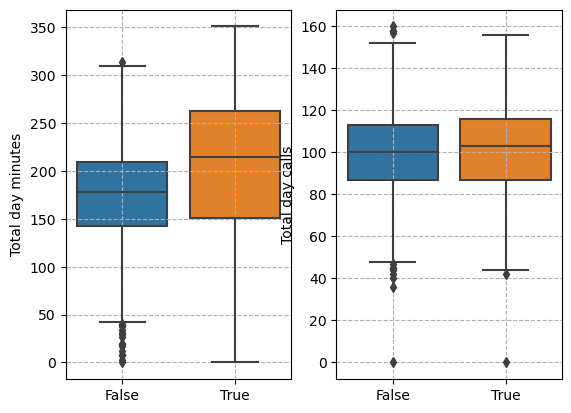

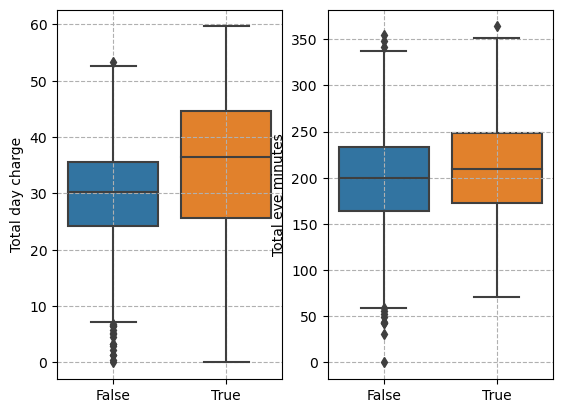

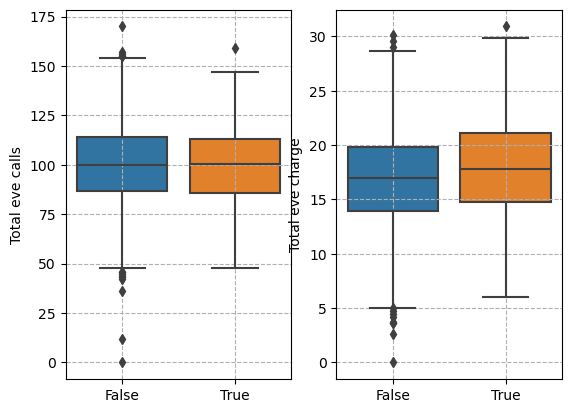

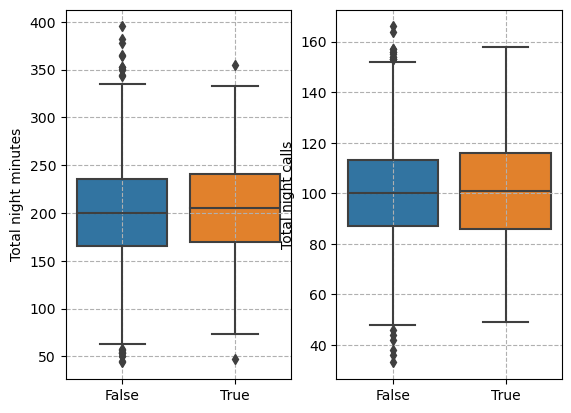

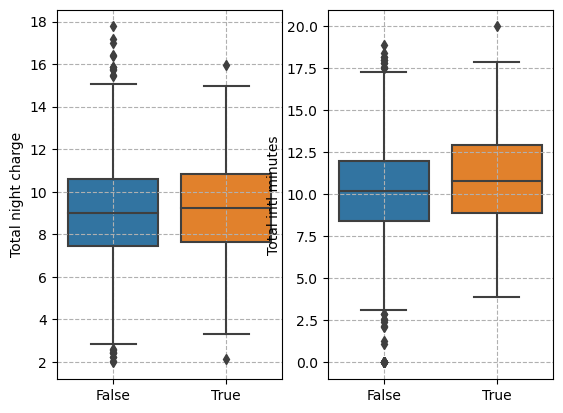

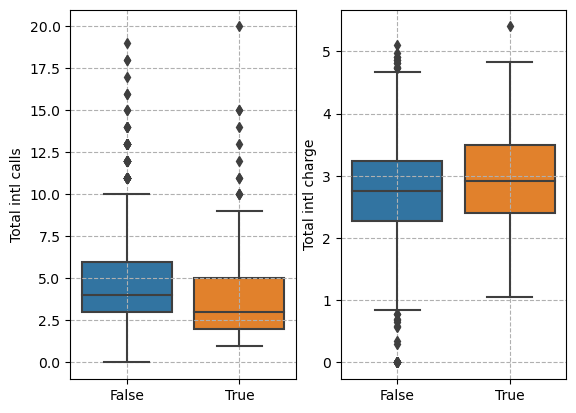

In [27]:
for i in range(0,len(num_cols),2):
    fig,ax = plt.subplots(1,2)
    sns.boxplot(df,y = num_cols[i], x = "Churn",ax=ax[0])
    sns.boxplot(df,y = num_cols[i+1], x = "Churn",ax=ax[1])
    for ax in ax:
        ax.grid(True, which='both', linestyle='--')
        ax.set(xlabel='')

This suggest that there might be outliers that we need to check for, we can also notice that churners tend to on avergae have values slightly bigger in every featurs other than total intl calls and Account length, which might make a bit of sense, since higher charge and expenditure might push customers to churn.

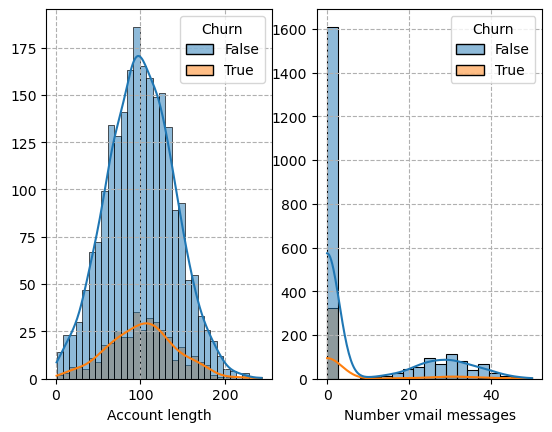

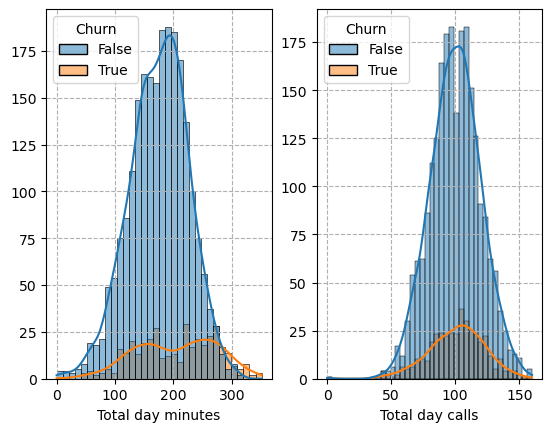

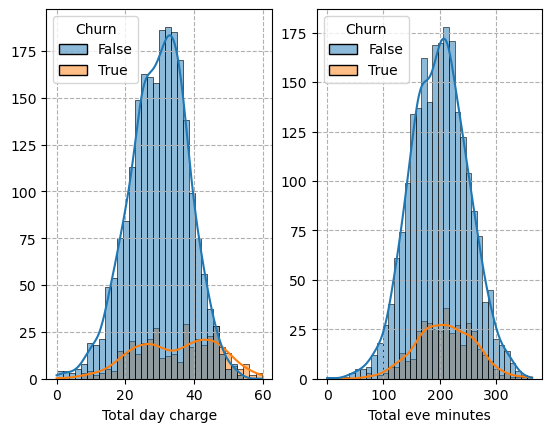

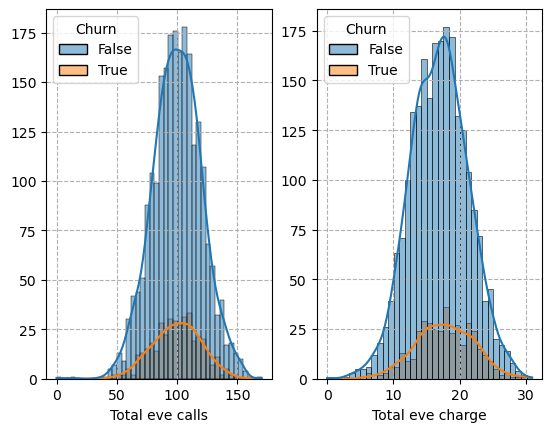

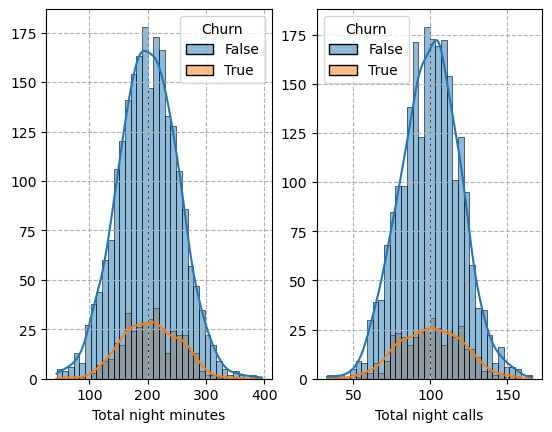

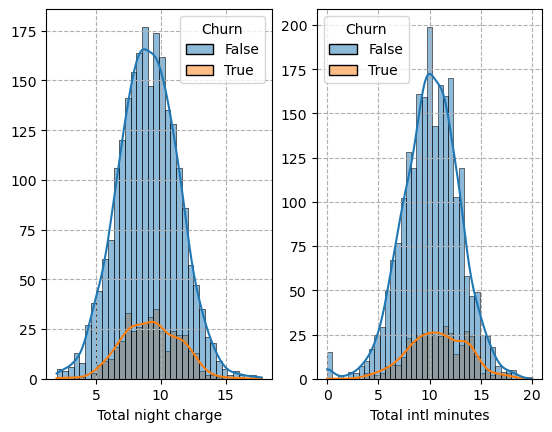

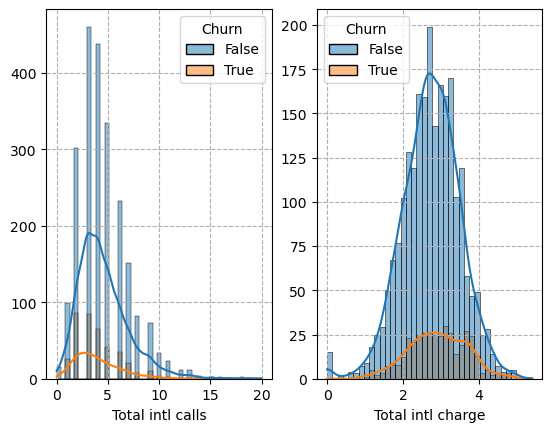

In [28]:
for i in range(0,len(num_cols),2):
    fig,ax = plt.subplots(1,2)
    sns.histplot(df,x = num_cols[i], hue = "Churn", kde = True,ax=ax[0])
    sns.histplot(df,x = num_cols[i+1], hue = "Churn", kde = True,ax=ax[1])
    for ax in ax:
        ax.grid(True, which='both', linestyle='--')
        ax.set(ylabel='')

## Are there outliers?

In [29]:
def out_zscore(data):
    outliers = []
    zscore = []
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    for i in data:
        z_score= (i - mean)/std 
        zscore.append(z_score)
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return set(outliers)

In [30]:
for col in num_cols:
    print(f"Outliers of {col} are: ",out_zscore(df[col]))

Outliers of Account length are:  {224, 225, 243, 221}
Outliers of Number vmail messages are:  {50}
Outliers of Total day minutes are:  {0.0, 2.6, 7.9, 7.8, 12.5, 345.3, 346.8, 350.8}
Outliers of Total day calls are:  {40, 0, 36}
Outliers of Total day charge are:  {0.0, 1.34, 2.13, 0.44, 58.7, 1.33, 58.96, 59.64}
Outliers of Total eve minutes are:  {0.0, 354.2, 42.2, 43.9, 42.5, 363.7, 31.2}
Outliers of Total eve calls are:  {0, 170, 12, 36}
Outliers of Total eve charge are:  {0.0, 2.65, 3.73, 3.61, 3.59, 30.91, 30.11}
Outliers of Total night minutes are:  {354.9, 43.7, 364.3, 45.0, 395.0, 364.9, 47.4, 377.5, 381.9}
Outliers of Total night calls are:  {33, 164, 36, 38, 166}
Outliers of Total night charge are:  {1.97, 2.03, 2.13, 15.97, 16.39, 17.19, 16.99, 17.77, 16.42}
Outliers of Total intl minutes are:  {0.0, 1.3, 1.1, 18.9, 20.0}
Outliers of Total intl calls are:  {12, 13, 14, 15, 16, 17, 18, 19, 20}
Outliers of Total intl charge are:  {0.0, 0.35, 0.3, 5.1, 5.4}


Even though the method detected many outliers, they don't look like actual outliers in the context of the dataset , so we are leaving them in.

## Is there multi-colinearity?

<AxesSubplot:>

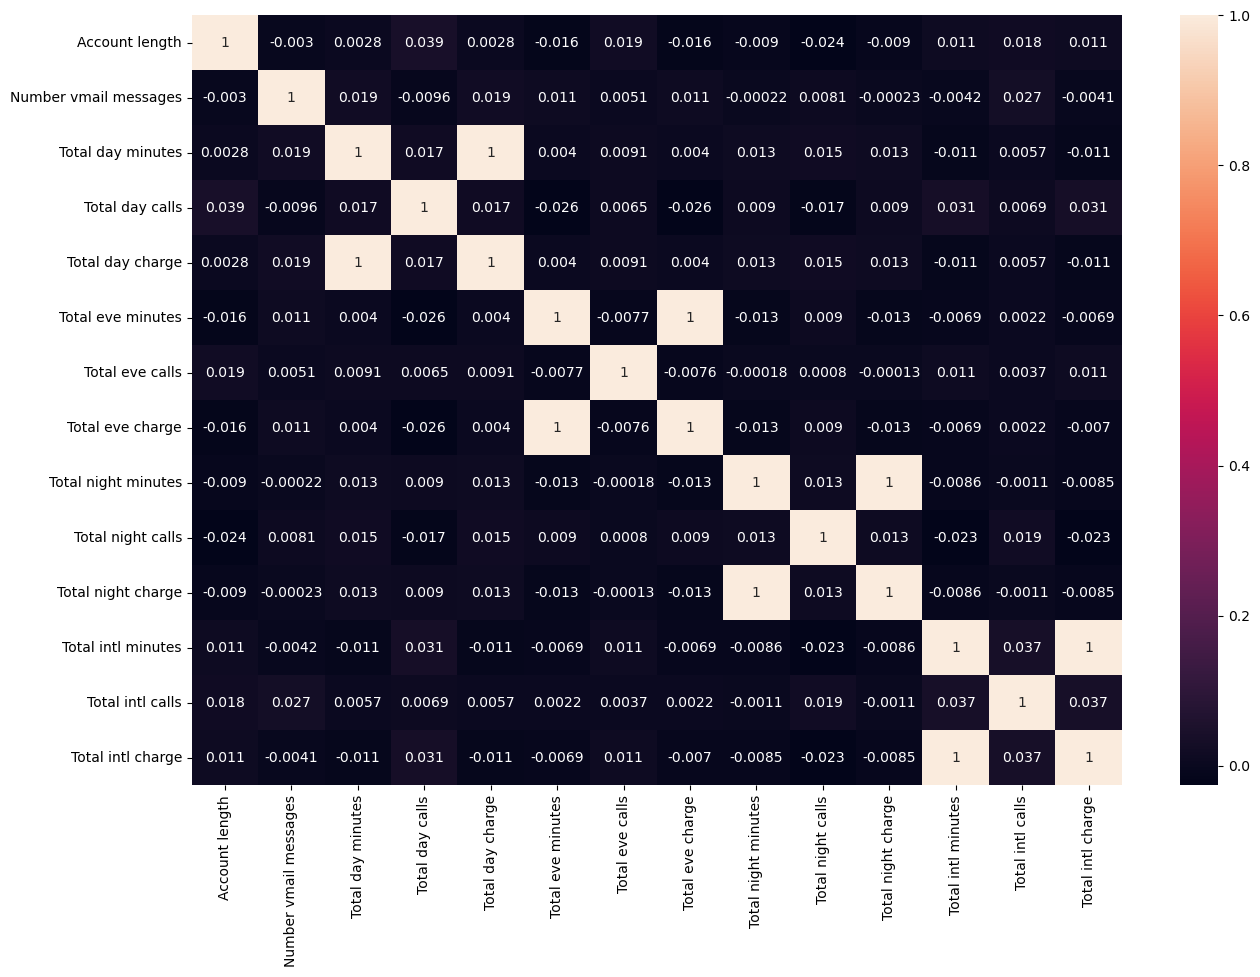

In [31]:
plt.figure(figsize = (15,10))
sns.heatmap(df[num_cols].corr(), annot = True)

We can notice a problem of correlation between some variables that we need to address!

In [32]:
to_drop = ["Total day minutes", "Total eve charge", "Total night minutes", "Total intl minutes"]

<AxesSubplot:>

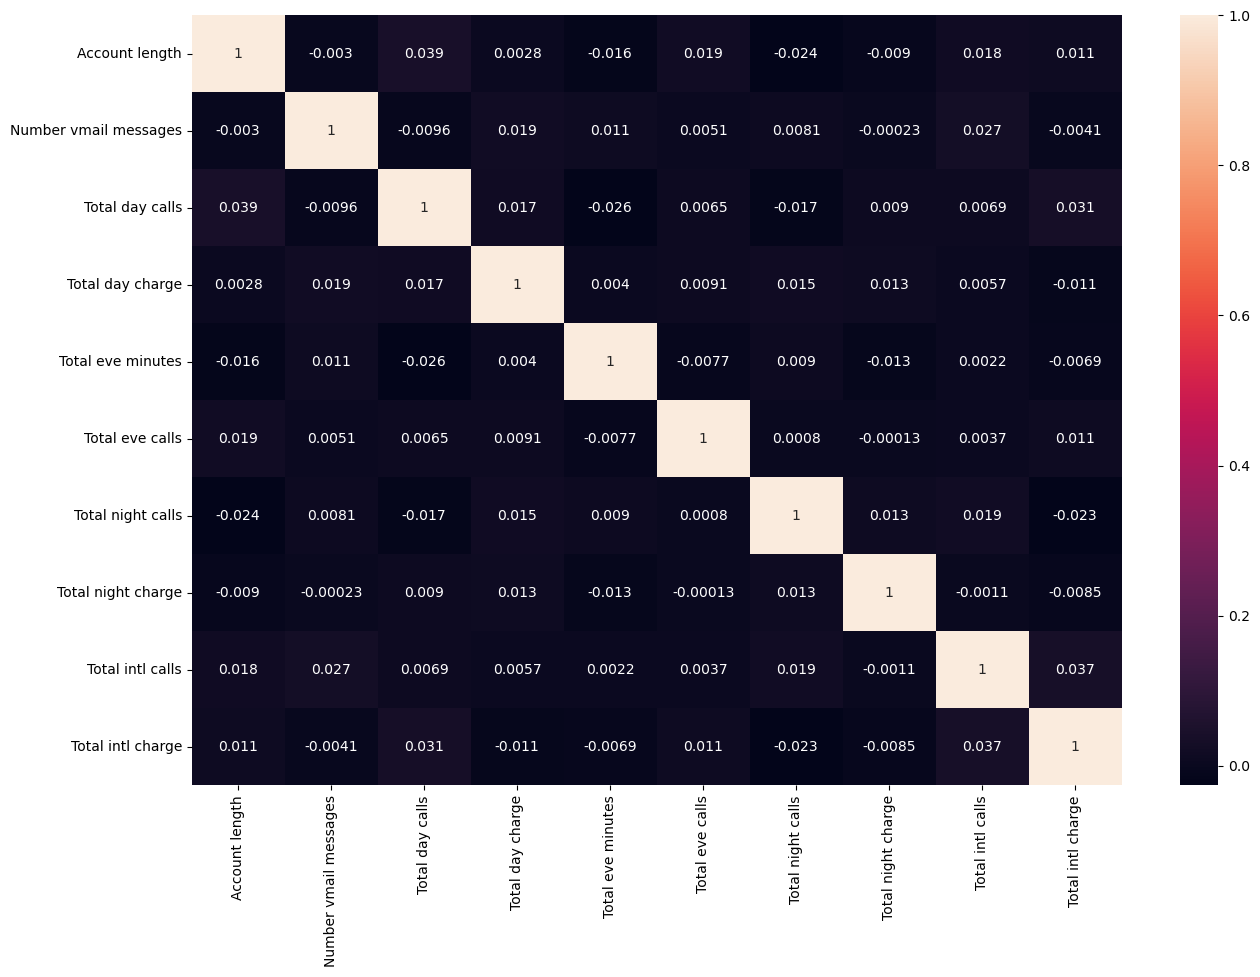

In [33]:
plt.figure(figsize = (15,10))
sns.heatmap(df[num_cols].drop(to_drop, axis = 1).corr(), annot = True)

Problem solved!

In [34]:
df.replace(["No","Yes"],[0,1], inplace = True)
df.replace([False,True],[0,1], inplace = True)

In [35]:
X = df.drop("Churn", axis = 1)
y = df["Churn"]

In [36]:
X.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,1,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,1,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,1,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify = y)

# 🔢 Model building:

We define a custom transformer class called "FeatureCreator" that creates new features for a dataset. The transformer takes in a list of columns to drop and creates four new features: "Total number of minutes", "Total minutes per call", "Average charge per call", and "International usage rate".

Using transformers is a good idea because they allow for easy and reproducible data preprocessing. Transformers can be applied to the data before training a model, which can improve the accuracy and efficiency of the model. In this case, the transformer creates new features that may be relevant to predicting whether a customer will churn or not.

In [38]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Transformer to create new features
    """
    def __init__(self,to_drop):
        self.to_drop = to_drop
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["Total number of minutes"] = X["Total day minutes"] + X["Total eve minutes"] + X["Total night minutes"]
        X["Total minutes per call"] = (X["Total number of minutes"]) / (X["Total day calls"] + X["Total eve calls"] + X["Total night calls"])
        X["Average charge per call"] = (X["Total day charge"] + X["Total eve charge"] + X["Total night charge"]) / (X["Total number of minutes"])
        X["International usage rate"] = (X["Total intl minutes"]) / (X["Total number of minutes"])
        
        return X.drop(self.to_drop, axis = 1)


We also define a scaling transformer used to scale the numerical columns and one-hot encode non-ordinal categorical columns in a Pandas DataFrame. 

In [39]:
class Scaling(BaseEstimator, TransformerMixin):
    """
    Transformer to return a scaled dataframe
    """
    def __init__(self,num_columns,cat_columns,onehot_columns, scaler=StandardScaler()):
        self.scaler = scaler
        self.num_columns = num_columns
        self.cat_columns = cat_columns
        self.onehot_columns = onehot_columns
    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_columns])
        return self

    def transform(self, X):
        X_scaled = pd.DataFrame(self.scaler.transform(X[self.num_columns]),
                                columns=X[self.num_columns].columns,
                                index=X[self.num_columns].index)
        dummies = pd.get_dummies(X[self.onehot_columns].astype("object")).iloc[:,:2]
        X = pd.concat([X[self.cat_columns],X_scaled], axis = 1)
        X = pd.concat([X,dummies], axis = 1)
        return X

In [40]:
cat_cols =["State","International plan","Voice mail plan", "Customer service calls"]
one_hot_col = ["Area code"]
num_cols = ["Account length",
    "Number vmail messages",
    'Total day calls',
    'Total day charge',
    'Total eve minutes',
    'Total eve calls',
    'Total night calls',
    'Total night charge',
    'Total intl calls',
    'Total intl charge',
    "Total number of minutes",
    "Total minutes per call",
    "Average charge per call",
    "International usage rate"]

In [41]:
pipeline = Pipeline(steps=[('feature_creation', FeatureCreator(to_drop)),('scaling', Scaling(num_cols,cat_cols,one_hot_col))  
                               ])

In [42]:
X_train_wf = pipeline.fit_transform(X_train)
X_test_wf = pipeline.transform(X_test)

In [43]:
def train_predict(X_train,X_test,y_train,y_test, model):
    """
    Train and return predictions 
    """
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return y_pred
    

In [44]:
random_state = 123
classifiers = []
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(LGBMClassifier(random_state = random_state))
classifiers.append(CatBoostClassifier(logging_level='Silent'))

In [45]:
kfold = StratifiedKFold(5)

In [46]:
accuracy = []
precision = []
recall = []
f1 = []
f2 =[]
roc_auc = []

for classifier in classifiers :
    y_pred = cross_val_predict(classifier,X_train_wf,y_train, cv = kfold)
    accuracy.append(accuracy_score(y_pred,y_train))
    precision.append(precision_score(y_pred,y_train))
    recall.append(recall_score(y_pred,y_train))
    f1.append(f1_score(y_pred,y_train))
    f2.append(fbeta_score(y_pred,y_train, beta = 2))
    roc_auc.append(roc_auc_score(y_pred,y_train))

In [47]:
index = ["AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","LGBMClassifier","CatBoostClassifier"]
df = pd.DataFrame({"Accuracy" : accuracy, "Precision" : precision, "Recall" : recall, "f1" : f1, "f2" : f2, "roc_auc" : roc_auc})
df.index = index

In [48]:
df.sort_values(["f2"],ascending = False)

,Accuracy,Precision,Recall,f1,f2,roc_auc
LGBMClassifier,0.964353,0.790323,0.957031,0.865724,0.918291,0.961192
CatBoostClassifier,0.962008,0.780645,0.949020,0.856637,0.909774,0.956396
RandomForest,0.956848,0.729032,0.965812,0.830882,0.906902,0.960777
GradientBoosting,0.957786,0.754839,0.943548,0.838710,0.898618,0.951604
ExtraTrees,0.921670,0.500000,0.928144,0.649895,0.792434,0.924632
AdaBoost,0.922608,0.722581,0.739274,0.730832,0.735874,0.846127


In [49]:
rfc_clf = RandomForestClassifier()

rf_param_grid = {"max_features": [10,15,19],
              "min_samples_split": [5,10],
              "n_estimators" :[1000,2000]}


grid = GridSearchCV(rfc_clf,param_grid = rf_param_grid, cv=kfold, scoring="f1", n_jobs= 4)

grid.fit(X_train_wf,y_train)

rfc_best = grid.best_estimator_

# Best score
print(grid.best_params_)
print(grid.best_score_)

{'max_features': 10, 'min_samples_split': 5, 'n_estimators': 1000}
0.8445542690385526


In [50]:
from sklearn.model_selection import RandomizedSearchCV

In [51]:
 parameters = {'depth'         : [7, 10],
                'learning_rate' : [0.01,0.02,0.04],
                'iterations'    : [70,90,100]
                 }
grid = GridSearchCV(CatBoostClassifier(logging_level ="Silent"),  scoring="f1", verbose = 3, param_grid = parameters, cv = kfold)
grid.fit(X_train_wf,y_train)

cat_best = grid.best_estimator_

# Best score
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END depth=7, iterations=70, learning_rate=0.01;, score=0.722 total time=   0.3s
[CV 2/5] END depth=7, iterations=70, learning_rate=0.01;, score=0.552 total time=   0.3s
[CV 3/5] END depth=7, iterations=70, learning_rate=0.01;, score=0.622 total time=   0.3s
[CV 4/5] END depth=7, iterations=70, learning_rate=0.01;, score=0.645 total time=   0.3s
[CV 5/5] END depth=7, iterations=70, learning_rate=0.01;, score=0.552 total time=   0.3s
[CV 1/5] END depth=7, iterations=70, learning_rate=0.02;, score=0.841 total time=   0.3s
[CV 2/5] END depth=7, iterations=70, learning_rate=0.02;, score=0.694 total time=   0.3s
[CV 3/5] END depth=7, iterations=70, learning_rate=0.02;, score=0.735 total time=   0.3s
[CV 4/5] END depth=7, iterations=70, learning_rate=0.02;, score=0.829 total time=   0.3s
[CV 5/5] END depth=7, iterations=70, learning_rate=0.02;, score=0.740 total time=   0.3s
[CV 1/5] END depth=7, iterations=70, learning_rat

In [52]:
y_pred = train_predict(X_train_wf,X_test_wf,y_train,y_test,cat_best)

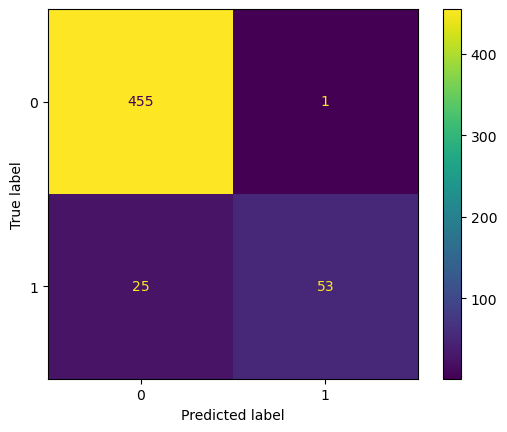

In [53]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       456
           1       0.98      0.68      0.80        78

    accuracy                           0.95       534
   macro avg       0.96      0.84      0.89       534
weighted avg       0.95      0.95      0.95       534



In [55]:
y_pred = train_predict(X_train_wf,X_test_wf,y_train,y_test,LGBMClassifier(random_state = random_state))

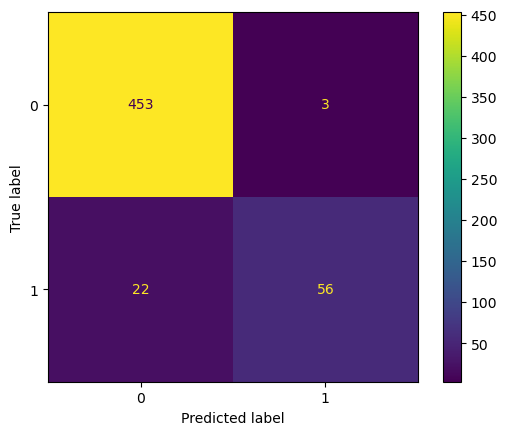

In [56]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [57]:
y_pred = train_predict(X_train_wf,X_test_wf,y_train,y_test,rfc_best)

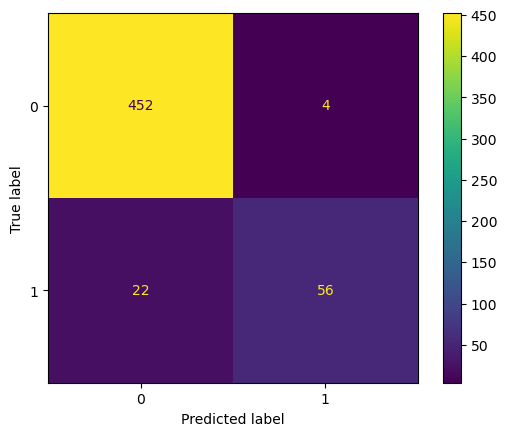

In [58]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       456
           1       0.93      0.72      0.81        78

    accuracy                           0.95       534
   macro avg       0.94      0.85      0.89       534
weighted avg       0.95      0.95      0.95       534



In [60]:
estimator = []
estimator.append(('RandomForest', rfc_best))
estimator.append(('CatBoost', cat_best))
estimator.append(('LGBM',LGBMClassifier(random_state = random_state)))

In [61]:
vc_soft = VotingClassifier(estimators = estimator, voting ='soft')

In [62]:
y_pred = train_predict(X_train_wf,X_test_wf,y_train,y_test, model = vc_soft)

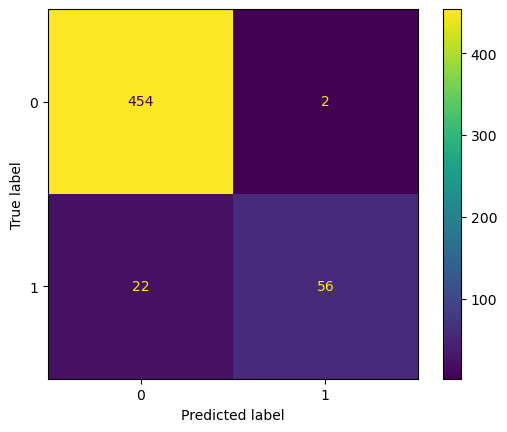

In [63]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       456
           1       0.97      0.72      0.82        78

    accuracy                           0.96       534
   macro avg       0.96      0.86      0.90       534
weighted avg       0.96      0.96      0.95       534



In [65]:
vc_hard = VotingClassifier(estimators = estimator, voting ='hard')

In [66]:
y_pred = train_predict(X_train_wf,X_test_wf,y_train,y_test, model = vc_hard)

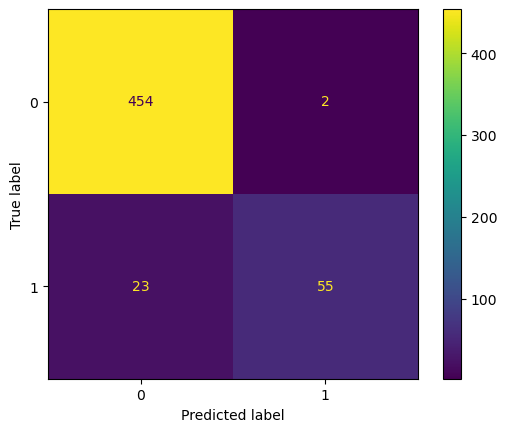

In [67]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [68]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       456
           1       0.96      0.71      0.81        78

    accuracy                           0.95       534
   macro avg       0.96      0.85      0.89       534
weighted avg       0.95      0.95      0.95       534



# 📈 Model Evaluation on test set : 

In [69]:
test_path = "/kaggle/input/telecom-churn-datasets/churn-bigml-20.csv"
test_set = pd.read_csv(test_path)

In [70]:
X_test = test_set.drop("Churn", axis = 1)
y_test = test_set["Churn"]

In [71]:
X_test["State"].replace(churn_less10,0, inplace = True)
X_test["State"].replace(churn_more10,1, inplace = True)
X_test["State"].replace(churn_more20,2, inplace = True)

In [72]:
X_test.replace(["No","Yes"],[0,1], inplace = True)
X_test.replace([False,True],[0,1], inplace = True)

In [73]:
X_test["Customer service calls"]=np.where(X_test["Customer service calls"] >= 4, 1,0 )

In [74]:
X_train = pipeline.fit_transform(X)
X_test = pipeline.transform(X_test)

In [75]:
y.value_counts()

0    2278
1     388
Name: Churn, dtype: int64

In [76]:
X_un,y_un = shuffle(X_train,y)

# amount of fraud classe: 310 rows.
X_churn = X_un.loc[y_un == 1]
X_non_churn = X_un.loc[y_un == 0][:388]

y_churn = y_un.loc[y_un == 1]
y_non_churn = y_un.loc[y_un == 0][:388]

X_undersampled = pd.concat([X_churn, X_non_churn])
y_undersampled = pd.concat([y_churn, y_non_churn])

In [77]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y)
print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({0: 2278, 1: 2278})


In [78]:
cat_cols = [0,1,2,17,18]
smote = SMOTENC(cat_cols,random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y)
print('Resampled dataset shape %s' % Counter(y_smote))

Resampled dataset shape Counter({0: 2278, 1: 2278})


In [79]:
def plot_roc_curve(y_test,y_pred, ax):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    ax.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel("False positve rate")
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC curve')
    ax.legend(loc='lower right')

In [80]:
models = [("Random Forest",rfc_best),('LightGBM',LGBMClassifier(random_state = random_state)),("CatBoost",cat_best),("Votintg Soft",vc_soft),("Voting hard",vc_hard)]


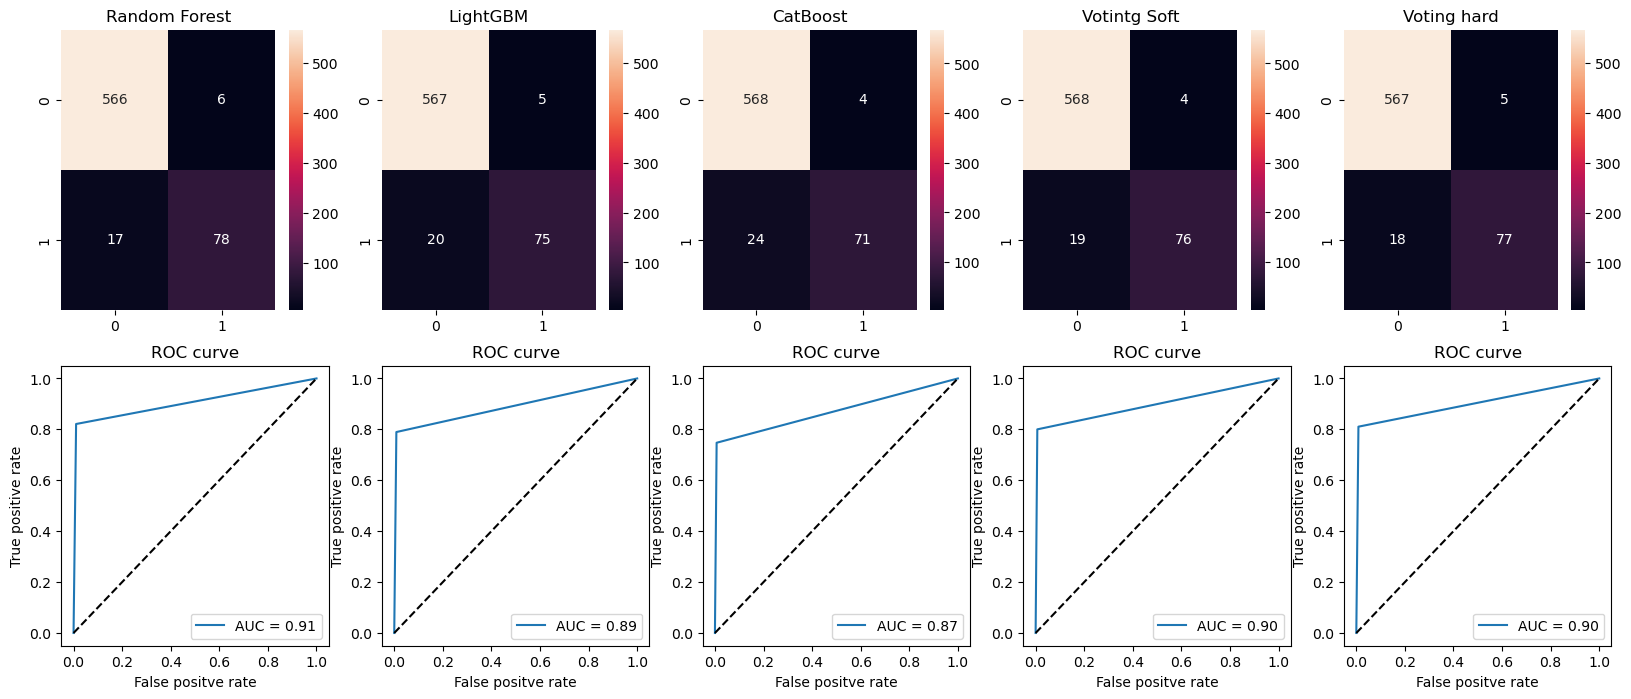

In [81]:
fig,ax = plt.subplots(2,5, figsize = (20,8))
for i,model in enumerate(models):
    ax[0,i].set_title(model[0])
    y_pred = train_predict(X_train,X_test,y,y_test,model = model[1])
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d',ax = ax[0,i])
    plot_roc_curve(y_test,y_pred,ax[1,i])
    

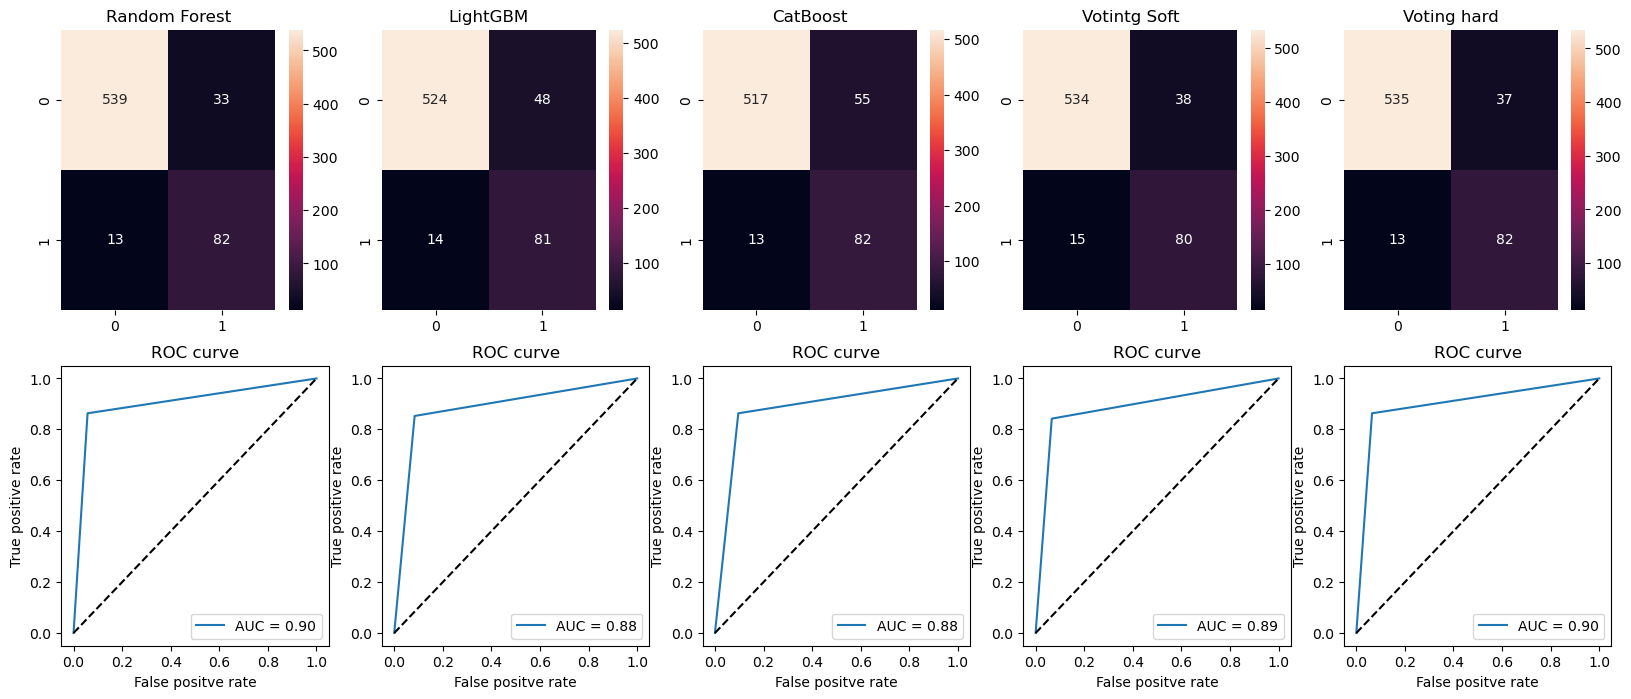

In [82]:
fig,ax = plt.subplots(2,5, figsize = (20,8))
for i,model in enumerate(models):
    y_pred = train_predict(X_undersampled,X_test,y_undersampled,y_test,model = model[1])
    ax[0,i].set_title(model[0])
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d',ax = ax[0,i])
    plot_roc_curve(y_test,y_pred,ax[1,i])

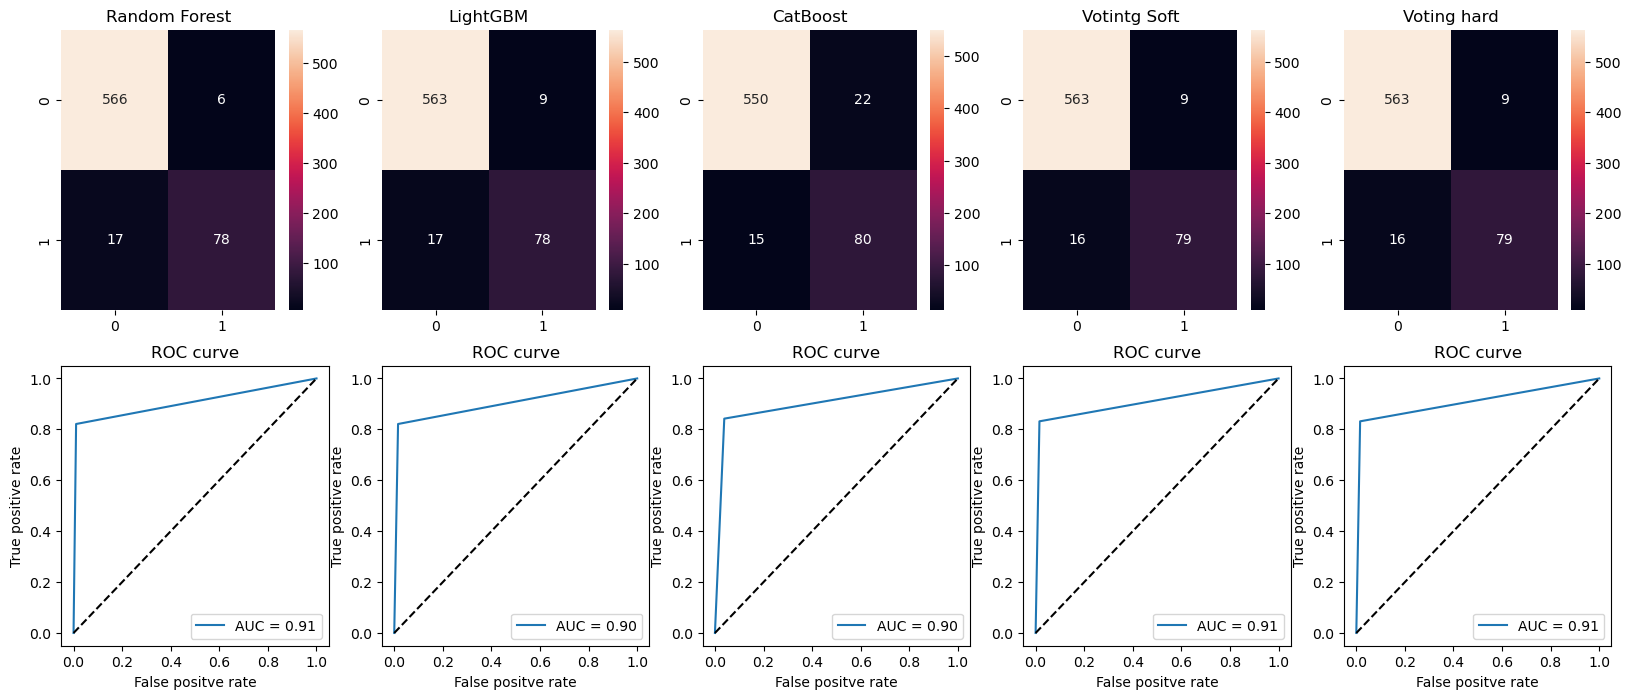

In [83]:
fig,ax = plt.subplots(2,5, figsize = (20,8))
for i,model in enumerate(models):
    ax[0,i].set_title(model[0])
    y_pred = train_predict(X_resampled,X_test,y_resampled,y_test,model = model[1])
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d',ax = ax[0,i])
    plot_roc_curve(y_test,y_pred,ax[1,i])

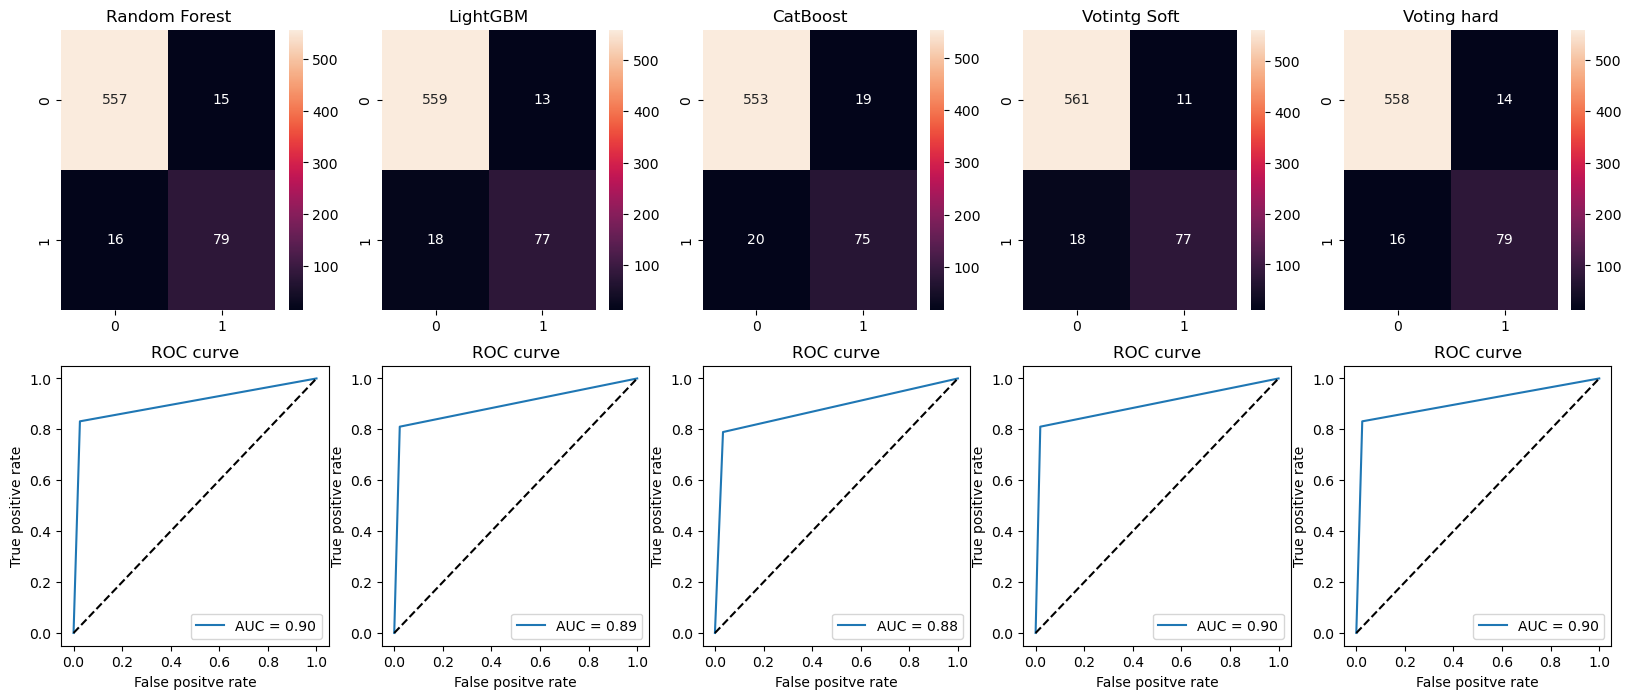

In [84]:
fig,ax = plt.subplots(2,5, figsize = (20,8))
for i,model in enumerate(models):
    ax[0,i].set_title(model[0])
    y_pred = train_predict(X_smote,X_test,y_smote,y_test,model = model[1])
    sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d',ax = ax[0,i])
    plot_roc_curve(y_test,y_pred,ax[1,i])

We can safely conclude that balancing in this case is not necessary and even remark that it can potentially worsen the performance, moreover we can choose RandomForest without balancing our data as our model with a good amount of confidence, however an argument could be made for Voting hard classifier with Oversampling as it performs equally as well.

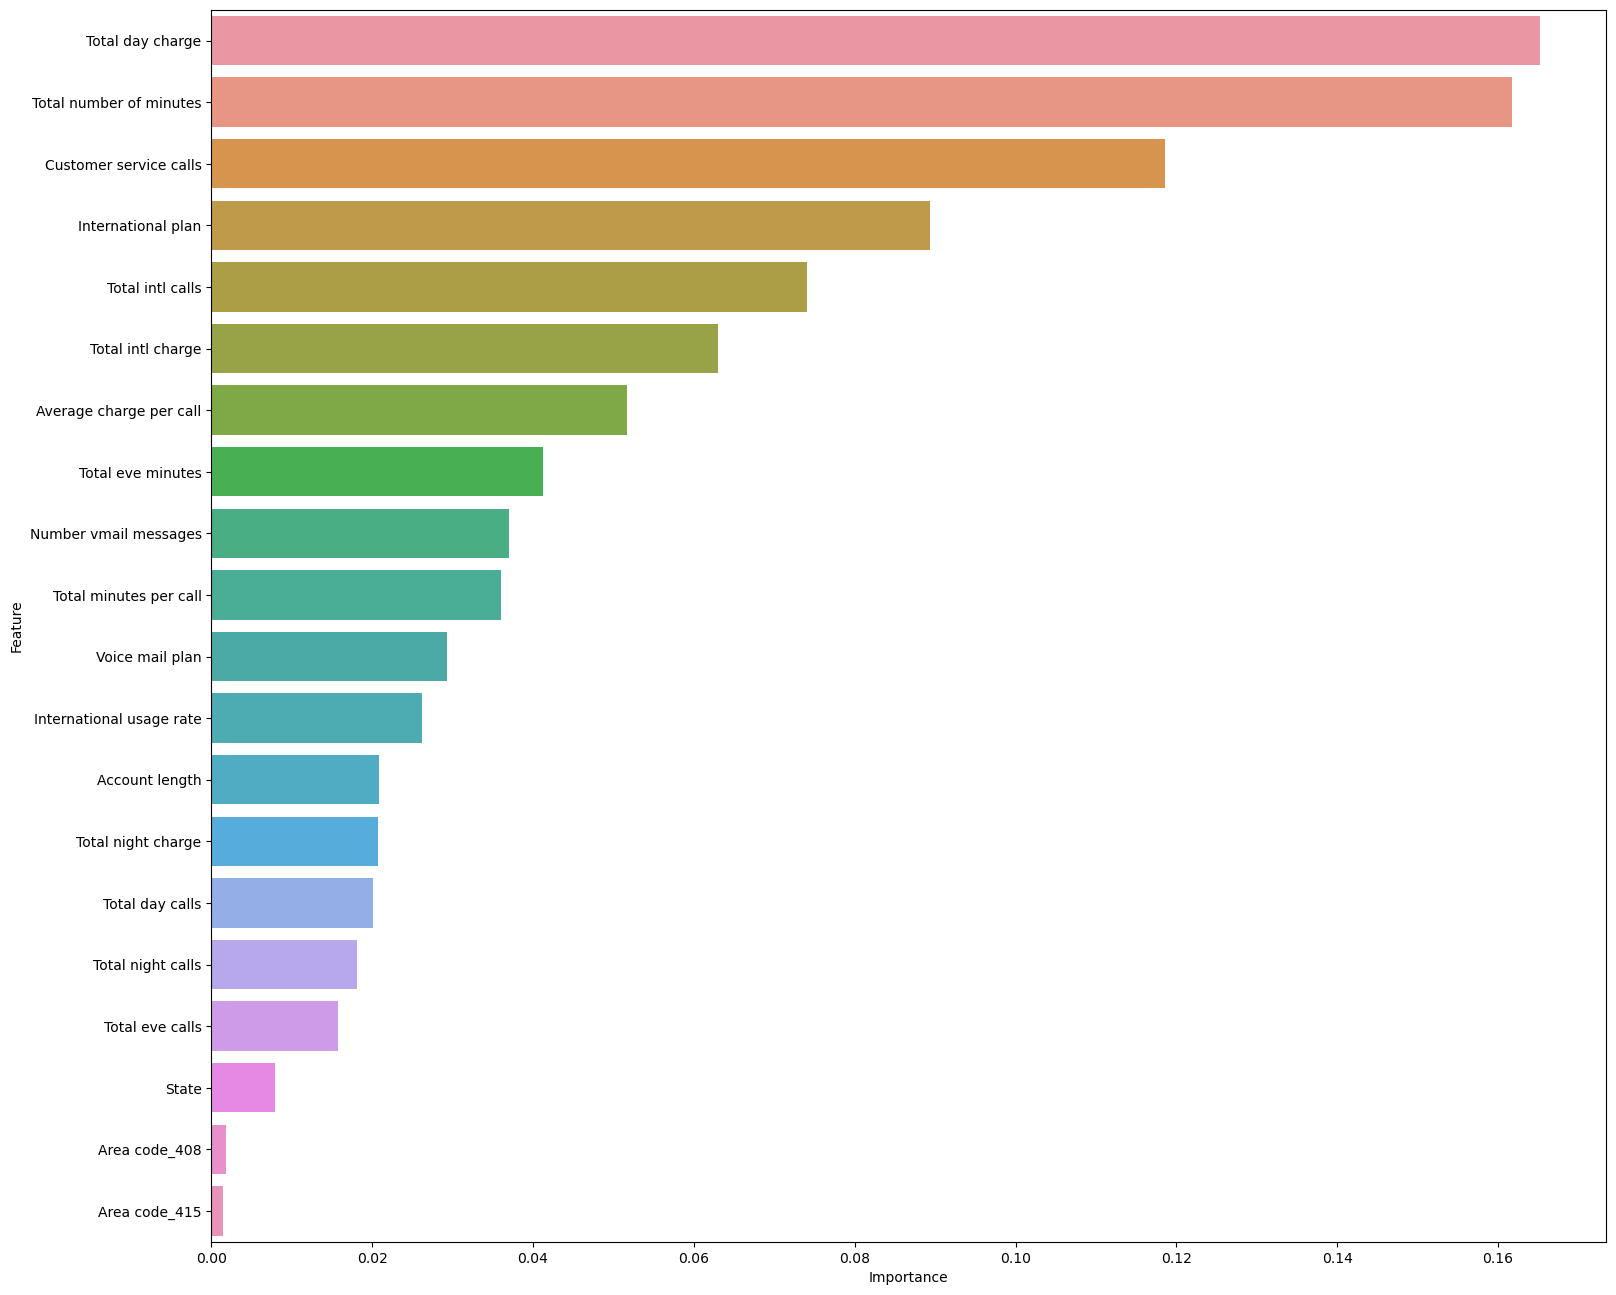

In [87]:
y_pred = train_predict(X_train,X_test,y,y_test,model = rfc_best)
importances = rfc_best.feature_importances_

importances_df = pd.DataFrame({"Feature": X_train.columns,
                               "Importance": importances})

importances_df = importances_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(18, 16))

sns.barplot(x="Importance", y="Feature", data=importances_df)
plt.show()

It looks like Total day charge and Total number of minutes are the two most important predictors in whether or not a customer would churn. A Customer with high customer service calls is also likely to churn. Moreover, while State brings some information it isn't as significant as other features. Finally, the area code, almost doesn't affect prediction which is also in line with the result of its chi_2_test result. 

Thank you for reading my notebook and I hope that you learned a little something from it 😊